# 第4回講義 宿題

## 課題. MNISTデータセットを多層パーセプトロン(MLP)で学習せよ

### 注意
- homework関数を完成させて提出してください
    - 訓練データはtrain_X, train_y, テストデータはtest_Xで与えられます
    - train_Xとtrain_yをtrain_X, train_yとvalid_X, valid_yに分けるなどしてモデルを学習させてください
    - test_Xに対して予想ラベルpred_yを作り, homework関数の戻り値としてください\
- pred_yのtest_yに対する精度(F値)で評価します
- 全体の実行時間がiLect上で60分を超えないようにしてください
- homework関数の外には何も書かないでください

- MLPの実装にTheanoなどのライブラリを使わないでください

### ヒント
- 出力yはone-of-k表現
- 最終層の活性化関数はソフトマックス関数, 誤差関数は多クラス交差エントロピー
- 最終層のデルタは教科書参照

次のような内容のコードが**事前**に実行されます

```python
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

import numpy as np


mnist = fetch_mldata('MNIST original')
mnist_X, mnist_y = shuffle(mnist.data, mnist.target.astype('int32'),
                           random_state=42)

mnist_X = mnist_X / 255.0

train_X, test_X, train_y, test_y = train_test_split(mnist_X, mnist_y,
                                                    test_size=0.2,
                                                    random_state=??)
```

次のセルのhomework関数を完成させて提出してください
- **上記のコード以外で必要なもの**は全て書いてください

In [10]:
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

import numpy as np


mnist = fetch_mldata('MNIST original')
mnist_X, mnist_y = shuffle(mnist.data, mnist.target.astype('int32'),
                           random_state=42)

mnist_X = mnist_X / 255.0

train_X, test_X, train_y, test_y = train_test_split(mnist_X, mnist_y,
                                                    test_size=0.2,
                                                    random_state=None)
train_X,train_y=train_X,train_y

In [11]:
%timeit
class MLP(object):
    def __init__(self, n_output, n_features, n_hidden=50,
                 epochs=500, eta=0.001,
                 alpha=0.001, decrease_const=0.0001, shuffle=True,
                 minibatches=10, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-0.8, 0.8,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-0.8, 0.8,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):

        return 1.0 / (1.0 + np.exp(-z))
        

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        else:
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        return X_new

    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y):
        self.cost_ = []
        self.test_cost_ =[]
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                     output=a3,
                                    w1=self.w1,
                                      w2=self.w2)

                self.cost_.append(cost)
                #compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
            
        return self

In [8]:
%timeit
nn = MLP(10,train_X.shape[1]).fit(train_X,train_y)
pred_y = nn.predict(test_X)
print(sum(pred_y==test_y)/len(pred_y),pred_y[:10],test_y[:10])

0.927714285714 [9 3 4 8 6 7 4 4 1 7] [9 8 4 8 6 7 7 4 1 7]


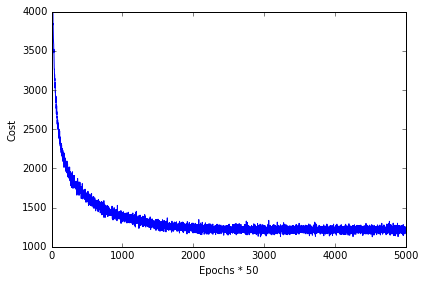

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%timeit
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([1000, 4000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()


In [13]:
%timeit
nn = MLP(len(set(test_y)),train_X.shape[1]).fit(train_X,train_y)
pred_y = nn.predict(test_X)
print(sum(pred_y==test_y)/len(pred_y),pred_y[:10],test_y[:10])

0.939857142857 [4 3 4 6 7 2 9 1 7 7] [4 3 4 4 7 2 9 1 7 7]
